In [1]:
import librosa # for mel-spectrogram estimation
import pydub # for opening .flac audio
from matplotlib import pyplot as plt
import numpy as np
from pydub import AudioSegment
from scipy.io.wavfile import read
import sounddevice as sd
import os
import glob
import random
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import gc

In [2]:
gc.collect()

40

# Check Data 

In [70]:
framerate, noisy_audio = read('audio_samples/' + '20-205-0000_noisy.wav')

In [80]:
sd.play(noisy_audio, framerate)

In [65]:
raw_clean_audio = AudioSegment.from_file('audio_samples/' + '20-205-0000.flac', format='flac').normalize()

In [66]:
clean_audio = raw_clean_audio.get_array_of_samples()
clean_audio = np.frombuffer(clean_audio, dtype=clean_audio.typecode)
clean_audio = clean_audio.astype('float')

framerate = raw_clean_audio.frame_rate

In [71]:
# normalized log-mel-spectrogram of clean and noisy audios
clean_mel = 1 + np.log(1.e-12 + librosa.feature.melspectrogram(clean_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)).T / 10.
noisy_mel = 1 + np.log(1.e-12 + librosa.feature.melspectrogram(noisy_audio, sr=16000, n_fft=1024, hop_length=256, fmin=20, fmax=8000, n_mels=80)).T / 10.

In [72]:
clean_mel

array([[2.88503026, 2.73499997, 2.62325815, ..., 1.9335595 , 1.92305889,
        1.92445403],
       [2.86082103, 2.79639663, 2.55450206, ..., 1.94081822, 1.91855426,
        1.93471433],
       [2.87750182, 2.78127816, 2.37662709, ..., 1.92682583, 1.95607311,
        1.92224161],
       ...,
       [2.85068386, 2.59444124, 2.43471619, ..., 1.98225499, 1.89999174,
        1.89042877],
       [2.81494271, 2.58716964, 2.51679905, ..., 1.97474943, 1.89825834,
        1.8859434 ],
       [2.70117933, 2.62367617, 2.51711509, ..., 1.94651587, 1.92642936,
        1.92945865]])

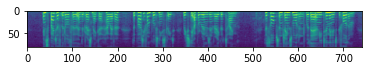

In [74]:
plt.imshow(clean_mel.T)

In [73]:
noisy_mel

array([[ 0.43956378,  0.59066063,  0.64798905, ..., -0.36530186,
        -0.35259946, -0.32903934],
       [ 0.5197188 ,  0.60047575,  0.59265159, ..., -0.33751936,
        -0.34896838, -0.33193056],
       [ 0.63248727,  0.71709145,  0.59935761, ..., -0.32564737,
        -0.30110273, -0.34817537],
       ...,
       [ 0.58907068,  0.66518507,  0.49580706, ..., -0.30565451,
        -0.41249062, -0.37354153],
       [ 0.57271436,  0.53501412,  0.49061519, ..., -0.30821187,
        -0.41390504, -0.39234239],
       [ 0.47391721,  0.63800492,  0.65511457, ..., -0.29532511,
        -0.37198359, -0.31306341]])

In [111]:
noisy_mel

array([[ 0.43956378,  0.59066063,  0.64798905, ..., -0.36530186,
        -0.35259946, -0.32903934],
       [ 0.5197188 ,  0.60047575,  0.59265159, ..., -0.33751936,
        -0.34896838, -0.33193056],
       [ 0.63248727,  0.71709145,  0.59935761, ..., -0.32564737,
        -0.30110273, -0.34817537],
       ...,
       [ 0.58907068,  0.66518507,  0.49580706, ..., -0.30565451,
        -0.41249062, -0.37354153],
       [ 0.57271436,  0.53501412,  0.49061519, ..., -0.30821187,
        -0.41390504, -0.39234239],
       [ 0.47391721,  0.63800492,  0.65511457, ..., -0.29532511,
        -0.37198359, -0.31306341]])

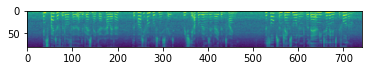

In [86]:
plt.imshow(noisy_mel.T)

In [118]:
noisy_mel.dtype

dtype('float64')

# Variables 

In [3]:
TRAIN_FOLDER = 'train'

CLEAN_TRAIN_DATA = os.path.join(TRAIN_FOLDER, 'clean')
NOISY_TRAIN_DATA = os.path.join(TRAIN_FOLDER, 'noisy')

# Check Max Value of Sound 

In [240]:
tmp_path = glob.glob(f'{CLEAN_TRAIN_DATA}/**/*.npy')

shapes = []
for i in tmp_path:
    img_shape = np.load(i).shape
    shapes.append(img_shape[0])

Mean duration: 758.94225
Median duration: 857.0


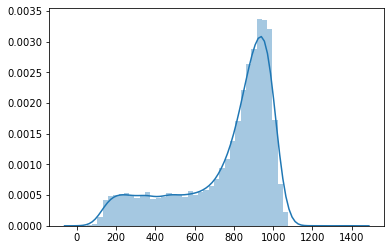

In [245]:
import seaborn as sns

print('Mean duration:', np.mean(shapes))
print('Median duration:', np.median(shapes))
sns.distplot(shapes)

# Generator 

In [5]:
batch_size = 32
epochs = 5

In [6]:

import random
a = random.choices(glob.glob(f'{CLEAN_TRAIN_DATA}/**/*.npy'), k=2)[0].replace('clean', 'noisy')
a = np.load(a).astype(np.float64)
a

array([[ 0.41723633,  0.33276367,  0.22973633, ..., -0.0484314 ,
        -0.16149902, -0.20263672],
       [ 0.32788086,  0.2109375 ,  0.22131348, ..., -0.03120422,
        -0.14318848, -0.16455078],
       [ 0.28540039,  0.08453369,  0.22277832, ..., -0.07098389,
        -0.16320801, -0.13061523],
       ...,
       [ 0.20556641, -0.0229187 ,  0.21984863, ..., -0.05905151,
        -0.03527832, -0.1149292 ],
       [ 0.22375488,  0.05160522,  0.16101074, ..., -0.0748291 ,
        -0.12890625, -0.22021484],
       [ 0.17834473,  0.08843994,  0.11743164, ..., -0.09118652,
        -0.1628418 , -0.21594238]])

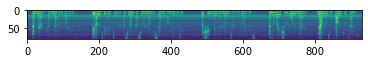

In [230]:
plt.imshow(a.T)

In [11]:
# def generate_train_data(CLEAN_TRAIN_DATA, sound_threshold=860):
    
#     clean_paths = glob.glob(f'{CLEAN_TRAIN_DATA}/**/*.npy')

#     noisy_paths = [i.replace('clean', 'noisy') for i in clean_paths]

#     batch_x = []
#     batch_y = []
#     for i in tqdm(range(len(clean_paths)), desc='NUMBER OF FILES'):

#         x = np.load(noisy_paths[i])
#         y = np.load(clean_paths[i])

#         if x.shape[0] > sound_threshold:
#             x = x[:sound_threshold, :]
#             y = y[:sound_threshold, :]

#         if x.shape[0] < sound_threshold:
#             shape_diff = sound_threshold - x.shape[0]
#             zero_mtrx = np.zeros((shape_diff, 80))

#             x = np.concatenate((x, zero_mtrx))
#             y = np.concatenate((y, zero_mtrx))


#         batch_x.append(x.astype(np.float64))
#         batch_y.append(y.astype(np.float64))

#     batch_y = np.array(batch_x) - np.array(batch_y)
#     batch_x = np.array(batch_x)

#     # batch_x --> (batch_size, threshold, 80, 1); batch_y --> (batch_size, threshold, 80, 1)
#     batch_x = batch_x.reshape(batch_x.shape[0], batch_x.shape[1], batch_x.shape[2], 1)
#     batch_y = batch_y.reshape(batch_y.shape[0], batch_y.shape[1], batch_y.shape[2], 1)

#     X_train_batch, X_test_batch, y_train_batch, y_test_batch = train_test_split(batch_x, batch_y, test_size=0.10, random_state=42)

#     return  X_train_batch, X_test_batch, y_train_batch, y_test_batch

In [11]:
train_paths = glob.glob(f'{CLEAN_TRAIN_DATA}/**/*.npy')
random.shuffle(train_paths)

In [16]:
prop = 10
thr = int((prop * len(train_paths)) / 100)

train_clean_paths = train_paths[:thr]
train_noisy_paths = [i.replace('clean', 'noisy') for i in train_paths[:thr]]

test_clean_paths = train_paths[thr:]
test_noisy_paths = [i.replace('clean', 'noisy') for i in train_paths[thr:]]

In [67]:
random.sample(range(5), 2)

[4, 1]

In [133]:
def data_generator(CLEAN_PATHS, NOISY_PATHS, sound_threshold=864, batch_size=32):
        
    for i in range(len(CLEAN_PATHS)):
        
        rand_indx = random.sample(range(len(CLEAN_PATHS)), batch_size)
        
        batch_x = []
        batch_y = []
        for i in rand_indx:
            x = np.load(NOISY_PATHS[i])
            y = np.load(CLEAN_PATHS[i])

            if x.shape[0] > sound_threshold:
                x = x[:sound_threshold, :]
                y = y[:sound_threshold, :]

            if x.shape[0] < sound_threshold:
                shape_diff = sound_threshold - x.shape[0]
                zero_mtrx = np.zeros((shape_diff, 80))

                x = np.concatenate((x, zero_mtrx))
                y = np.concatenate((y, zero_mtrx))
                
            batch_x.append(x)
            batch_y.append(y)
            
        x = np.array(batch_x)
        y = np.array(batch_y)

        y = x - y

        x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
        y = y.reshape(y.shape[0], y.shape[1], x.shape[2], 1)

        yield x, y


In [134]:
train_generator = data_generator(train_clean_paths, train_noisy_paths)
test_generator = data_generator(test_clean_paths, test_noisy_paths)

In [232]:
# import IPython.display as ipd

# ipd.Audio(x[0], rate=16000)

# Model 

In [21]:
import keras 

Using TensorFlow backend.


In [135]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def unet(pretrained_weights = None,input_size = (None,None,1)):
    
    #size filter input
    size_filter_in = 16
    #normal initialization of weights
    kernel_init = 'he_normal'
    #To apply leaky relu after the conv layer 
    activation_layer = None
    inputs = Input(input_size)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
    conv6 = LeakyReLU()(conv6)
    up7 = Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
    conv7 = LeakyReLU()(conv7)
    up8 = Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(), metrics = ['mse'])

    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [136]:
model = unet(pretrained_weights='weights/model_unet.h5')

In [137]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_334 (Conv2D)             (None, None, None, 1 160         input_16[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_321 (LeakyReLU)     (None, None, None, 1 0           conv2d_334[0][0]                 
__________________________________________________________________________________________________
conv2d_335 (Conv2D)             (None, None, None, 1 2320        leaky_re_lu_321[0][0]            
___________________________________________________________________________________________

In [138]:
model.fit_generator(generator=train_generator,
                    validation_data=test_generator,
                    steps_per_epoch=50,
                    epochs=5,
                    validation_steps=16)

Epoch 1/5
50/50 [==============================] - 1182s 24s/step - loss: 0.0225 - mean_squared_error: 0.0457 - val_loss: 0.0367 - val_mean_squared_error: 0.0751
Epoch 2/5
50/50 [==============================] - 1186s 24s/step - loss: 0.0183 - mean_squared_error: 0.0372 - val_loss: 0.0221 - val_mean_squared_error: 0.0446
Epoch 3/5
50/50 [==============================] - 1136s 23s/step - loss: 0.0170 - mean_squared_error: 0.0344 - val_loss: 0.0556 - val_mean_squared_error: 0.1114
Epoch 4/5
50/50 [==============================] - 1161s 23s/step - loss: 0.0157 - mean_squared_error: 0.0317 - val_loss: 0.0630 - val_mean_squared_error: 0.1260
Epoch 5/5
50/50 [==============================] - 1199s 24s/step - loss: 0.0155 - mean_squared_error: 0.0314 - val_loss: 0.1241 - val_mean_squared_error: 0.2483


In [151]:
model.save_weights('weights/denoising_model.h5')

#  Validate

In [139]:
from sklearn.metrics import mean_squared_error

In [140]:
VALIDATE_FOLDER = 'val'

CLEAN_VAL = os.path.join(VALIDATE_FOLDER, 'clean')
NOISY_VAL = os.path.join(VALIDATE_FOLDER, 'noisy')

In [141]:
all_noisy_files = glob.glob(f'{NOISY_VAL}/**/*.npy')
all_clean_files = glob.glob(f'{CLEAN_VAL}/**/*.npy')

In [142]:
val_iter = data_generator(all_clean_files, all_noisy_files, batch_size=1)

In [143]:
clean, noisy = next(val_iter)

In [144]:
noisy.shape

(1, 864, 80, 1)

In [145]:
y_pred = model.predict(noisy)

In [146]:
true = noisy - clean
y_pred.shape

(1, 864, 80, 1)

In [150]:
mean_squared_error(true.reshape(864, 80), y_pred.reshape(864, 80))

0.21957165748846705